<h1 style="font-size:3rem;color:maroon;">Regression Moddelling for Gas Production</h1>


<h1 style="font-size:2rem;color:gray;">Time Series forecasting</h1>


<h1 style="font-size:2rem;color:red;">1.0.0 Libraries</h1>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Normalization
from sklearn.preprocessing import StandardScaler

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE

#evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
import warnings
warnings.filterwarnings('ignore')

<h1 style="font-size:2rem;color:red;">1.1.0 Datasets</h1>

In [126]:
df = pd.read_csv("biogasdf_ready.csv", parse_dates=['date'])
df['Month'] = df['date'].dt.month
df['Hour'] = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour

In [127]:
bio1_phase0 = df[(df['bio_id'] == 1) & (df['phase_test'] == 0)].reset_index()
bio1_phase1 = df[(df['bio_id'] == 1) & (df['phase_test'] == 1)].reset_index()
bio1_phase2 = df[(df['bio_id'] == 1) & (df['phase_test'] == 2)].reset_index()
bio1_phase3 = df[(df['bio_id'] == 1) & (df['phase_test'] == 3)].reset_index()
bio2_phase0 = df[(df['bio_id'] == 2) & (df['phase_test'] == 0)].reset_index()
bio2_phase1 = df[(df['bio_id'] == 2) & (df['phase_test'] == 1)].reset_index()
bio2_phase2 = df[(df['bio_id'] == 2) & (df['phase_test'] == 2)].reset_index()
bio2_phase3 = df[(df['bio_id'] == 2) & (df['phase_test'] == 3)].reset_index()

In [128]:
print(f"bio1_phase0 : {bio1_phase0.shape}")
print(f"bio1_phase1 : {bio1_phase1.shape}")
print(f"bio1_phase2 : {bio1_phase2.shape}")
print(f"bio1_phase3 : {bio1_phase3.shape}")
print(f"bio2_phase0 : {bio1_phase0.shape}")
print(f"bio2_phase1 : {bio1_phase1.shape}")
print(f"bio2_phase2 : {bio1_phase2.shape}")
print(f"bio2_phase3 : {bio1_phase3.shape}")

bio1_phase0 : (5109, 14)
bio1_phase1 : (10875, 14)
bio1_phase2 : (4919, 14)
bio1_phase3 : (3653, 14)
bio2_phase0 : (5109, 14)
bio2_phase1 : (10875, 14)
bio2_phase2 : (4919, 14)
bio2_phase3 : (3653, 14)


Bio1_phase1 and Bio2_phase1 has high number of entries

In [129]:
# using bio1_phase1
data = bio1_phase1.sort_values(by='date',ascending=True).reset_index()

In [130]:
#Extracting last day
data_last_day = data[(data['date'] == '2022-02-28')]

# sorting using hours
data_last_days_hour = data.sort_values(by="Hour", ascending=True)

In [131]:
# Group by hours
data_hourly_group = data_last_days_hour.groupby("Hour").mean().reset_index()
data_hourly_group = data_hourly_group.drop(columns=["level_0","index","bio_id", "phase_test","Month"], axis=1)

In [132]:
# creating lags for the last 24hrs
data_columns = ['gas_temp', 'gas_umidity',"air_temp","ground_temp", "fluid_temp"]
lags = 24
for feature in data_columns:
    for lag in range(1, lags + 1):
        data_hourly_group[f'{feature}_lag_{lag}'] = data_hourly_group[feature].shift(lag)

In [134]:
lagged_data = data_hourly_group
lagged_data = lagged_data.fillna(0)

In [137]:
# creating data and target variables
X = lagged_data.drop('dm3_gas', axis=1)

y = lagged_data['dm3_gas']

In [138]:
X_train, X_test,y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((19, 127), (5, 127), (19,), (5,))

In [139]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

<h1 style="font-size:3rem;color:blue;">3.0.0 Modelling</h1>

In [141]:
# iteratng through several models to get the best performing one.

models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=3, random_state=42),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=1)
}

for name, model in models.items():
    model.fit(X_train_scaled_filled, y_train)
    print(f"{name}: {model.score(X_test_scaled_filled, y_test)}")

RandomForestRegressor: 0.267717127691941
DecisionTreeRegressor: 0.3436084220218032
Ridge: 0.8814565937582834
Lasso: -0.011604796803907913


Ridge Regressor performes better

<h1 style="font-size:2rem;color:blue;">3.1.0 Grid Search</h1>

<h1 style="font-size:1.5rem;color:blue;">3.1.1 ridge Regression</h1>

In [142]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {"alpha": [1, 10, 100, 290, 500],
              "fit_intercept": [True, False],
              "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
             }

grid = GridSearchCV(estimator=Ridge(alpha=1), param_grid = parameters, cv = 2, n_jobs=-1)


grid.fit(X_train_scaled_filled, y_train)

best_model = grid.best_estimator_
print(f"Best model: {best_model}")
print(f"Best score: {grid.best_score_}")


Best model: Ridge(alpha=290, fit_intercept=False, solver='svd')
Best score: -0.451743339444998
CPU times: total: 219 ms
Wall time: 5.91 s


In [143]:
best_model.fit(X_train_scaled_filled, y_train)
best_model.score(X_test_scaled_filled, y_test)

-0.7714742551644636

Performance serverely dropped

<h1 style="font-size:1.5rem;color:blue;">3.1.2 grid Search in  Random forest Regressor</h1>

In [145]:
para_grids = {
            "n_estimators" : [10,50,100],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }

estimator=RandomForestRegressor()

grid = GridSearchCV(estimator, para_grids)


grid.fit(X_train_scaled_filled, y_train)

best_model = grid.best_estimator_
print(f"Best model: {best_model}")
print(f"Best score: {grid.best_score_}")

Best model: RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=10)
Best score: 0.14604484502115683


After gridsearching the model it performs worse

<h1 style="font-size:2.5rem;color:blue;">3.2.0 RandomForest Regressor</h1>

In [146]:
rfr = RandomForestRegressor()
rfr_model = rfr.fit(X_train_scaled_filled, y_train)

In [147]:
rfr_model.score(X_test_scaled_filled, y_test)

0.3154135771216816

In [148]:
preds = rfr_model.predict(X_train_scaled_filled)

In [149]:
modelled = pd.DataFrame({'preds' : preds,
                        'Hour' : X_train.Hour,
                        'dm3' : y_train.values}
                )

In [150]:
modelled = modelled.sort_values(by="Hour", ascending=True)

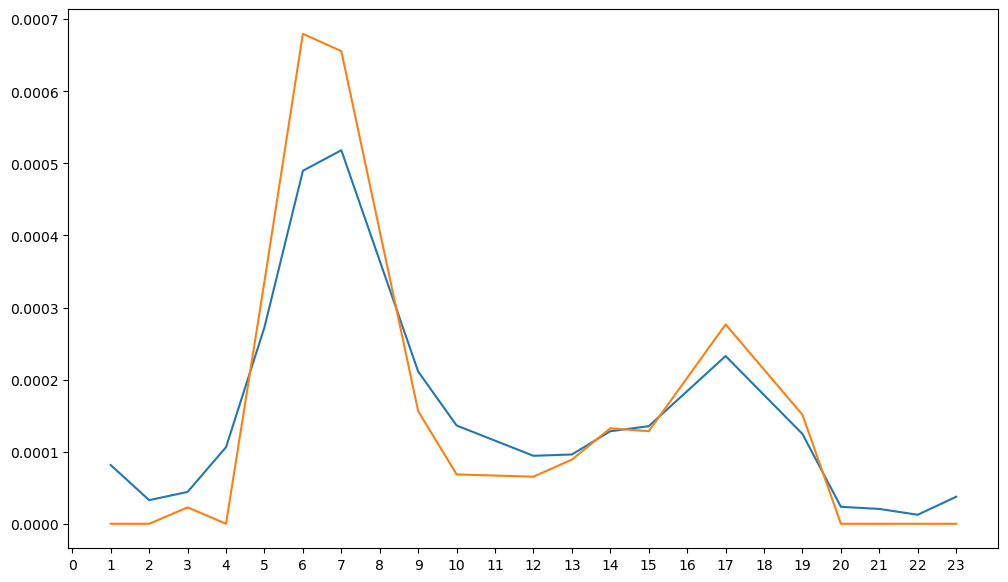

In [151]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled.Hour, modelled.preds)
ax.plot(modelled.Hour, modelled.dm3)
ax.set_xticks(np.arange(0, 24, step=1))
plt.show()

The Random Forest doesn't predict quite to be relied on

<h1 style="font-size:2.5rem;color:blue;"> 3.2.0 Ridge Regression Model</h1>

In [152]:
ridge = Ridge(alpha=1)
ridge = ridge.fit(X_train_scaled_filled, y_train)
ridge.score(X_test_scaled_filled, y_test)

0.8814565937582834

In [153]:
#ridge predictions
preds_ridge = ridge.predict(X_train_scaled_filled)

In [154]:
modelled_ridge = pd.DataFrame({'preds' : preds_ridge,
                        'Hour' : X_train.Hour,
                        'dm3' : y_train.values}
                )

In [155]:
modelled_ridge = modelled_ridge.sort_values(by="Hour", ascending=True)

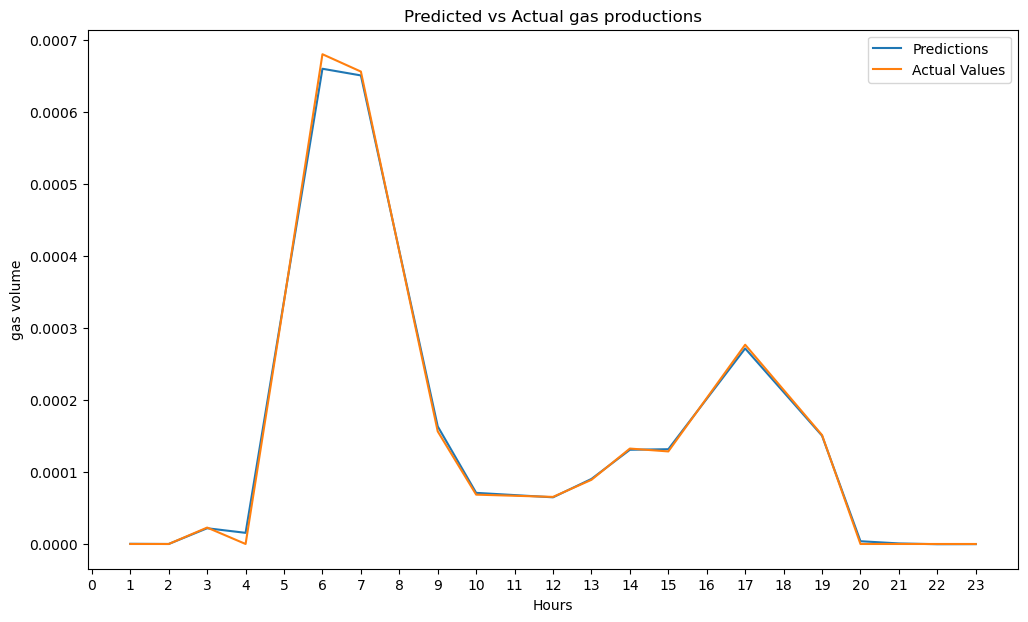

In [156]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled_ridge.Hour, modelled_ridge.preds, label = "Predictions")
ax.plot(modelled_ridge.Hour, modelled_ridge.dm3, label = "Actual Values")
ax.set_xticks(np.arange(0, 24, step=1))
ax.set_ylabel("gas volume")
ax.set_xlabel("Hours")
plt.title("Predicted vs Actual gas productions")
plt.legend()
plt.show()

Ridge Model performed quite well

## Neural Network for Multi-Output Regression

In [138]:
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

# get the dataset
X = data_hourly_grouped

y = data_hourly_group['dm3_gas']

model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(len(y)))


model.compile(loss='mae', optimizer='adam')
    
 
X_train, X_test,y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

model.fit(X_train, y_train, verbose=0, epochs=100)



mae = model.evaluate(X_test, y_test, verbose=0)
print(mae)


0.8750513195991516


Sequential Model had a lower  score that of Ridge Regression model

<h1 style="font-size:2.5rem;color:maroon;">Hyperparameter Tune Ridge Regression</h1>

<h1 style="font-size:2rem;color:purple;">1.1 Feature Selection</h1>

<h1 style="font-size:1.5rem;color:blue;">1.1.0Recursive Feature Elimination</h1>

In [161]:
X = data_hourly_grouped

y = data_hourly_group['dm3_gas']


ridge = Ridge(alpha=1)
rfe = RFE(ridge, n_features_to_select= 125)  
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
rfe_data = X[selected_features]

X_train, X_test,y_train,  y_test = train_test_split(rfe_data, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

In [162]:
rfe_data = X[selected_features]

In [163]:
#X_train, X_test,y_train,  y_test = train_test_split(rfe_data, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((19, 125), (5, 125), (19,), (5,))

In [164]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

In [95]:
ridge = Ridge(alpha=1)
ridge = ridge.fit(X_train_scaled_filled, y_train)
ridge.score(X_test_scaled_filled, y_test)

0.9462254208143506

In [98]:
#ridge predictions
preds_ridge = ridge.predict(X_train_scaled_filled)

In [99]:
modelled_ridge = pd.DataFrame({'preds' : preds_ridge,
                        'Hour' : X_trainn.Hour,
                        'dm3' : y_train.values}
                )

In [100]:
modelled_ridge = modelled_ridge.sort_values(by="Hour", ascending=True)

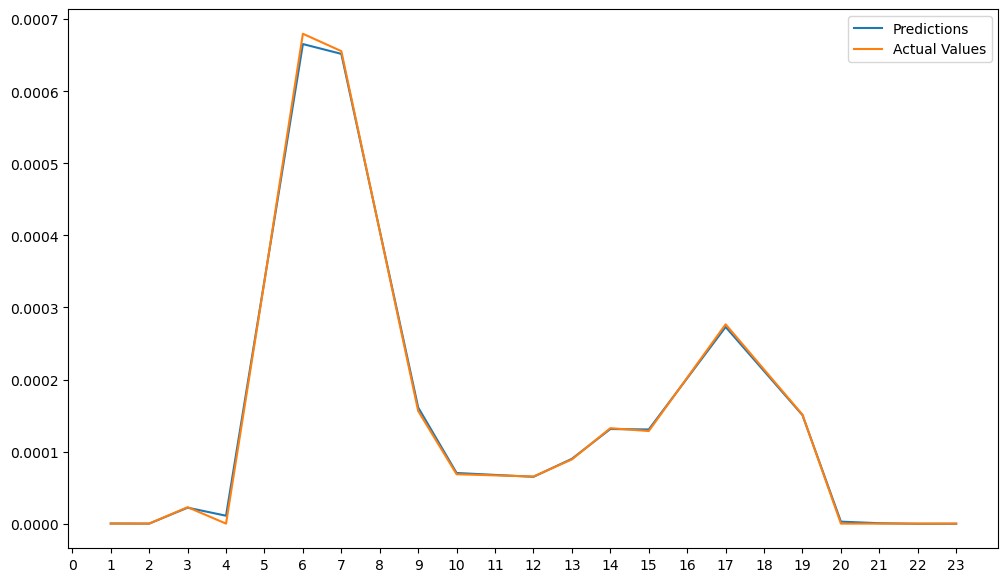

In [123]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled_ridge.Hour, modelled_ridge.preds, label = "Predictions")
ax.plot(modelled_ridge.Hour, modelled_ridge.dm3, label = "Actual Values")
ax.set_xticks(np.arange(0, 24, step=1))
plt.legend()
plt.show()

<h1 style="font-size:2.5rem;color:maroon;">Creating  Input values</h1>

### A simple demo of input to prediction

In [157]:
# Key-in the inputs
gas_temp = float(input("Gas Temperatures: "))
gas_umidity = float(input("gas humidity"))
air_temp = float(input("gair_temp"))
ground_temp = float(input("gground_temp"))
fluid_temp = float(input("fluid_temp"))

Gas Temperatures: 12
gas humidity12
gair_temp323
gground_temp11
fluid_temp33


In [158]:
inputs = pd.DataFrame({'gas_temp' : [gas_temp], 'gas_umidity' : [gas_umidity],  "air_temp"  : [air_temp], "ground_temp" : [ground_temp], "fluid_temp" : [fluid_temp] })

In [159]:
def prediction(inputs):
    data_columns = ['gas_temp', 'gas_umidity',"air_temp","ground_temp", "fluid_temp"]
    lags = 24
    for feature in data_columns:
        for lag in range(1, lags + 1):
            inputs[f'{feature}_lag_{lag}'] = inputs[feature].shift(lag)
    inputs = inputs.fillna(0)
    inputs_scaled = scaler.fit_transform(inputs)
    preed = ridge.predict(inputs_scaled)
    return preed

In [160]:
preed = prediction(inputs)

ValueError: X has 125 features, but Ridge is expecting 127 features as input.